In [1]:
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import requests
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from scipy.optimize import fmin

from utils import plot_galaxies, plot_samples, stdout_disabled

sns.set_palette("Set2")

## The Price is Right

In [2]:
# Set empirical prior parameters (i.e., guessed from past shows)
mu_prior = 35000
std_prior = 7500

# Our "data" is what we believe the prices to be
mu_data = [3000, 12000]
std_data = [500, 3000]

In [3]:
def price_model():
    true_price = pyro.sample("true_price", dist.Normal(mu_prior, std_prior))
    price_1 = pyro.sample("price_1", dist.Normal(mu_data[0], std_data[0]))
    price_2 = pyro.sample("price_2", dist.Normal(mu_data[1], std_data[1]))

    price_estimate = price_1 + price_2

    pyro.sample("lh", dist.Normal(price_estimate, 3000), obs=true_price)

In [4]:
nuts_kernel = NUTS(price_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run()

Sample: 100%|██████████| 2400/2400 [00:26, 89.04it/s, step size=4.90e-01, acc. prob=0.931] 


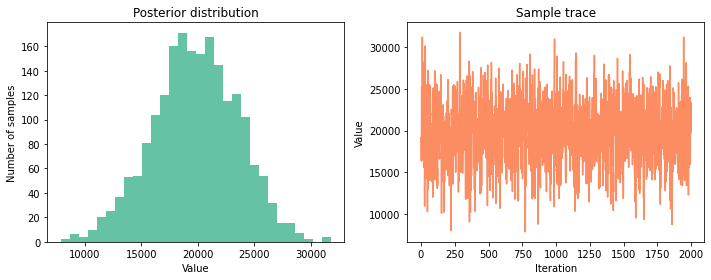

In [5]:
# The true price now has a higher expectation than the initial 15,000$ = 3,000$ + 12,000$ guess
# Because in historical data we usually see higher prices around 35,000$
# Or, the other way round, we expect less than 35,000$ because our guesses are low in comparison
plot_samples(mcmc.get_samples()["true_price"].detach().cpu().numpy())

## Stock Loss

In [6]:
# We first simulate some data
n_data = 500
xx = 0.025 * dist.Normal(0, 1).sample([n_data])
yy = 0.5 * xx + 0.01 * dist.Normal(0, 1).sample([n_data])

In [7]:
def linear_regression(xx, yy):
    alpha = pyro.sample("alpha", dist.Normal(0, 100))
    beta = pyro.sample("beta", dist.Normal(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))

    means = alpha + beta * xx

    with pyro.plate("plate", yy.shape[0]):
        pyro.sample("y", dist.Normal(means, sigma), obs=yy)

In [8]:
nuts_kernel = NUTS(linear_regression)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(xx, yy)

Sample: 100%|██████████| 2400/2400 [01:59, 20.03it/s, step size=9.27e-02, acc. prob=0.928]


In [9]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

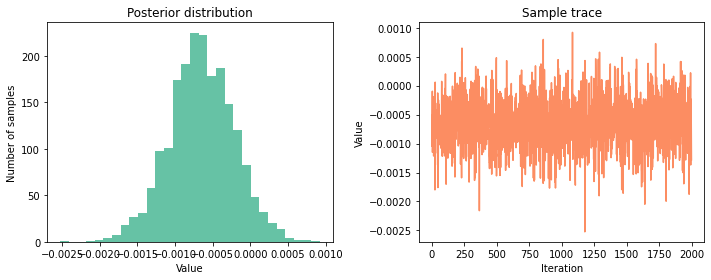

In [10]:
# True alpha: 0.5
plot_samples(mcmc_samples["alpha"])

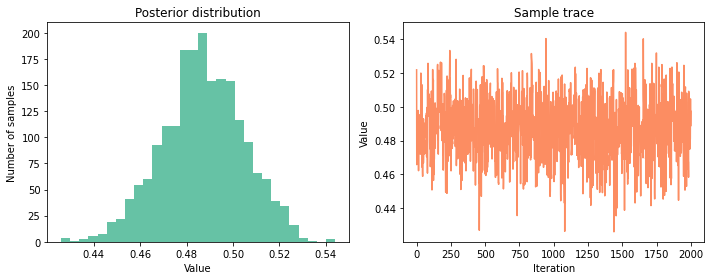

In [11]:
# True beta: 0.5
plot_samples(mcmc_samples["beta"])

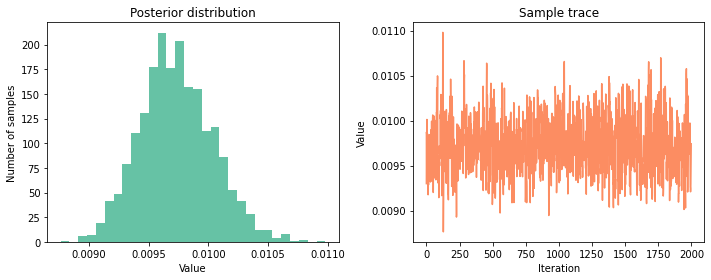

In [12]:
# True sigma: 0.01
plot_samples(mcmc_samples["sigma"])

In [13]:
# Next, we incorporate the loss function definied in the tutorial

In [14]:
def stock_loss(price, pred, coef=500):
    sol = np.zeros_like(price)
    idx = price * pred < 0
    sol[idx] = coef * pred ** 2 - np.sign(price[idx]) * pred + abs(price[idx])
    sol[~idx] = abs(price[~idx] - pred)
    return sol

In [15]:
n_pred = 50

preds = np.zeros(n_pred)
signals = np.linspace(xx.min(), xx.max(), n_pred)
noise = mcmc_samples["sigma"] * dist.Normal(0, 1).sample([len(mcmc_samples["sigma"])]).numpy()

for i, signal in enumerate(signals):
    outcomes = mcmc_samples["alpha"] + mcmc_samples["beta"] * signal + noise
    to_min = lambda pred: stock_loss(outcomes, pred).mean()
    preds[i] = fmin(to_min, 0, disp=False)

In [16]:
# Least squares estimates follow the formula for simple linear regression
ls_coef = np.cov(xx, yy)[0, 1] / np.var(xx.numpy())
ls_intercept = yy.mean() - ls_coef * xx.mean()

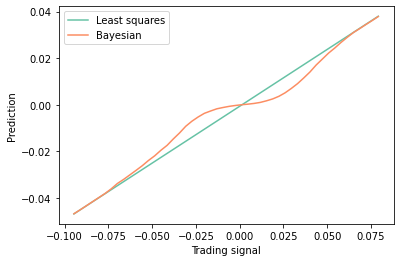

In [17]:
fig, ax = plt.subplots()

ax.plot(signals, ls_coef * signals + ls_intercept.numpy(), label="Least squares")
ax.plot(signals, preds, label="Bayesian")

ax.set_ylabel("Prediction")
ax.set_xlabel("Trading signal")
ax.legend()

plt.show()

## Dark Worlds

In [18]:
# Download the data from Kaggle: https://www.kaggle.com/c/DarkWorlds

In [19]:
# Get the custom loss function
code = requests.get("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/DarkWorldsMetric.py")

with open("dark_metric.py", "w") as f:
    f.write(code.text)

In [20]:
from dark_metric import main_score

In [21]:
halos = np.loadtxt("data/Training_Halos.csv", skiprows=1, usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9], delimiter=",")

In [22]:
sky_i = 3

sky = np.loadtxt(f"data/Train_Skies/Training_Sky{sky_i}.csv", skiprows=1, usecols=[1, 2, 3, 4], delimiter=",")

halo = halos[sky_i - 1, [3, 4]]
halo_data = halos[sky_i - 1]

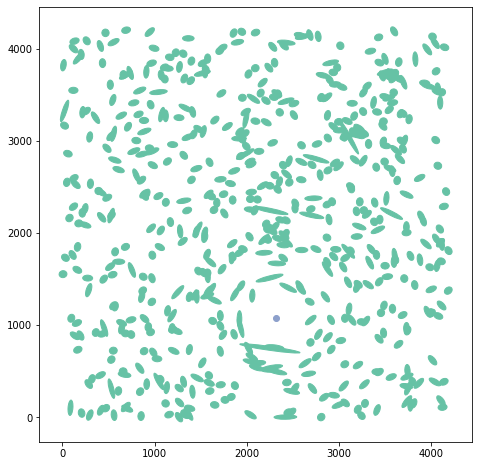

In [23]:
plot_galaxies(sky, size=80, true_halo=halo)

In [24]:
def euclidean_distance(a: torch.tensor, b: torch.tensor):
    return ((a - b) ** 2).sum(axis=1) ** 0.5


def f_distance(a: torch.tensor, b: torch.tensor, c: torch.tensor):
    return torch.max(euclidean_distance(a, b), c)[:, None]


def tangential_distance(gal: torch.tensor, hal: torch.tensor):
    diff = gal - hal
    angle = 2 * torch.atan(diff[:, 1] / diff[:, 0])
    return torch.stack([-torch.cos(angle), -torch.sin(angle)], axis=-1)

In [25]:
def dark_model(galaxies):
    mass_large = pyro.sample("mass_large", dist.Uniform(40.0, 180.0))
    xy = pyro.sample("xy", dist.Uniform(0.0, 4200.0).expand([2]))

    with pyro.plate("plate", galaxies.shape[0]):
        f_dist = f_distance(galaxies[:, :2], xy, torch.tensor(240.0))
        t_dist = tangential_distance(galaxies[:, :2], xy)
        el_loc = mass_large / f_dist * t_dist

        pyro.sample("el", dist.MultivariateNormal(el_loc, torch.eye(2) * 0.22), obs=galaxies[:, 2:])

In [26]:
nuts_kernel = NUTS(dark_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(torch.tensor(sky).float())

Sample: 100%|██████████| 1200/1200 [01:57, 10.23it/s, step size=3.37e-02, acc. prob=0.903]


In [27]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

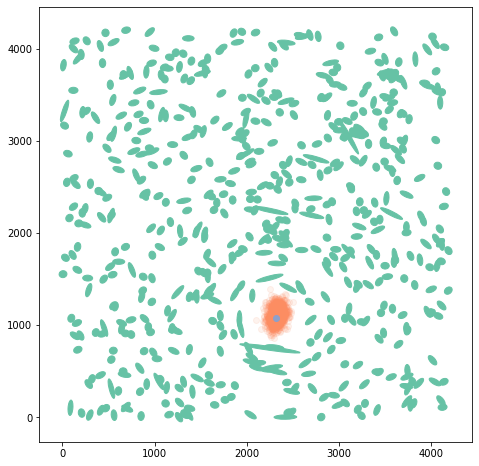

In [28]:
plot_galaxies(sky, size=80, halos=mcmc_samples["xy"], true_halo=halo)

In [29]:
# To make use of the loss function, we now calculate the loss from every point in 4200x4200
# to every sampled point in xy and choose the point with the lowest average loss as final output

In [30]:
# This could take really long so we will compute the loss for just 10 samples instead of 1,000
n_samples_used = 10

scores = defaultdict(lambda: np.zeros(n_samples_used))

xy_min = np.floor(mcmc_samples["xy"].min(axis=0))
xy_max = np.ceil(mcmc_samples["xy"].max(axis=0))

with stdout_disabled():
    for x, y in itertools.product(np.arange(xy_min[0], xy_max[0]), np.arange(xy_min[1], xy_max[1])):
        for i in range(n_samples_used):
            scores[(x, y)] = main_score(
                nhalo_all=halo_data[0].reshape(1, 1),
                x_true_all=np.array([x]).reshape(1, 1),
                y_true_all=np.array([y]).reshape(1, 1),
                x_ref_all=halo_data[1].reshape(1, 1),
                y_ref_all=halo_data[2].reshape(1, 1),
                sky_prediction=mcmc_samples["xy"][i].reshape(1, 2),
            )

In [31]:
scores = {k: np.mean(v) for k, v in scores.items()}
best_prediction = sorted(scores.keys(), key=scores.get)[0]

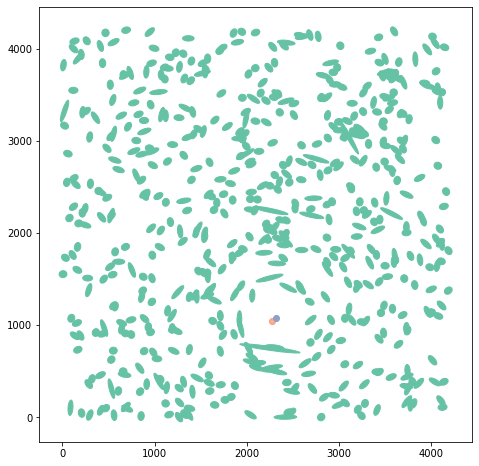

In [32]:
plot_galaxies(sky, size=80, halos=np.tile(best_prediction, 10).reshape(10, 2), true_halo=halo)

In [33]:
main_score(
    nhalo_all=halo_data[0].reshape(1, 1),
    x_true_all=halo_data[3].reshape(1, 1),
    y_true_all=halo_data[4].reshape(1, 1),
    x_ref_all=halo_data[1].reshape(1, 1),
    y_ref_all=halo_data[2].reshape(1, 1),
    sky_prediction=np.array(best_prediction).reshape(1, 2),
)

Your average distance in pixels you are away from the true halo is 55.6736104451653
Your average angular vector is 0.9999999999999999
Your score for the training data is 1.0556736104451652


1.0556736104451652